# ASTR 596: FDS Homework 7: Gaussian Processes


### Last week, you worked on finding periodic planet signals in the light curve of Kepler-90, a star that is photometrically stable. The periodogram worked nicely because 

### a) we cleaned the light curve to squelch red noise
### b) the signals really were periodic and we could implictly make a strong assumption about the covariance between points.

### Life gets harder when the star itself has quasi-periodic variations because it has a magnetic field and is rotating (ruh oh...) 

In [53]:
%matplotlib inline
import numpy as np
from astropy.table import Table, unique
import matplotlib.pyplot as plt
# ! pip install george 
from george import kernels, GP
from george.modeling import Model
from scipy.optimize import minimize
import scipy.stats as st
import emcee
import corner

In [54]:
plt.style.use("seaborn")

tab = Table.read('KIC2157356.txt',format='ascii')
tab['quarter'] = tab['quarter'].astype('int')

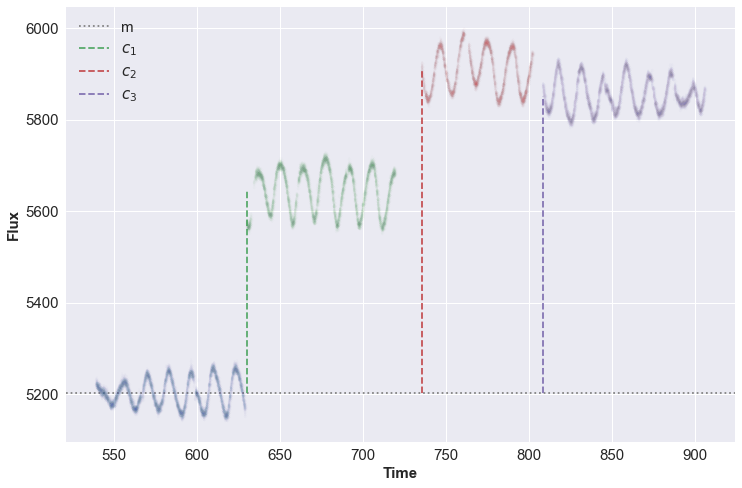

In [55]:
plt.figure(figsize = (12,8))
qs = sorted(np.unique(tab['quarter']))
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    plt.errorbar(t['time'],t['flux'], yerr=t['error'], marker='.', linestyle='None', alpha=0.01)
    meanflux = np.mean(t['flux'])
    cycle_map[q] = ind
    means.append(meanflux)
    if i == 0:
        plt.axhline(meanflux, label='m', color='grey', ls=":")
    else:

        vmin = means[0]
        vmax = meanflux

        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--') 


plt.xlabel('Time', weight = "bold", size = 15)
plt.ylabel('Flux', weight = "bold", size = 15)
plt.legend(frameon=False, prop = {"size":15})
plt.tick_params("both", labelsize = 15)

### As you can see there is some kind of periodic signal, but it's not perfectly regular. There is also the usual offsets between Kepler photometry in different cycles.

### You'll need four parameters to describe constants ($m, c_1, c_2, c_3$) to renormalize the flux to the first cycle, illustrated in the figure above. 
### $m$ specifies the mean of the Gaussian process, while $c_1, c_2, c_3$ are nuisance parameters. 

### You know how to implement a model with one common zeropoint and multiple offsets - this was what you did on your midterm.


### You'll also need some model to describe the quasi-periodic oscillations. There's no good way to write down a model in real for these in real space because stellar magnetic fields are incredibly complicated. 

### Instead we'll write down a model for the covariance between the observations and use a Gaussian process to model the star. You can model quasi-periodic correlation structure as something periodic + something that varies the periodicity smoothly:

## $$k(t_i, t_j) = A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|t_i - t_j|\right) -  \frac{|t_i-t_j|^2}{\lambda}) \right) $$

### This is another 4 parameters, ($A, \Gamma_1, P, \lambda$) parameters for a total of 8: ($m, c_1, c_2, c_3, A, \Gamma_1, P, \lambda$)

<hr>

### Q1: To implement the GP correlations, use the `george` package to construct this quasi-periodic kernel
https://george.readthedocs.io/en/latest/user/kernels/


### In particular, you should be able to combine `ExpSine2Kernel` and `ExpSquaredKernel` to get a model for the quasi-periodic oscillations.

ExpSine2Kernel :  

>${k(\mathbf{x}_i,\,\mathbf{x}_j) =
        \exp \left( -\Gamma\,\sin^2\left[
            \frac{\pi}{P}\,\left|x_i-x_j\right|
        \right] \right)}$
        
ExpSquaredKernel : 

>${k(r^2) = \exp \left ( -\frac{r^2}{2} \right )}$

Kernel we want: 

>${A \cdot
        \exp \left( -\Gamma\,\sin^2\left[
            \frac{\pi}{P}\,\left|x_i-x_j\right|
        \right] \right) \cdot \exp \left ( -\frac{\left|x_i-x_j\right|^2}{2} \right ) = 
         A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|x_i - x_j|\right) -  \frac{|x_i-x_j|^2}{\lambda}) \right)}$

In [117]:
# Parameters (𝐴, Γ_1, 𝑃, 𝜆); I'm guessing random values
guess_A, guess_gamma, guess_period, guess_lambda = 2., 1., 1., 1.

# Create a kernel
k = guess_A * kernels.ExpSine2Kernel(gamma = guess_gamma, log_period = guess_period) * kernels.ExpSquaredKernel(metric = guess_lambda)

### Q2: To implement the full model, read how to use `george`'s modeling protocol:
https://george.readthedocs.io/en/latest/tutorials/model/

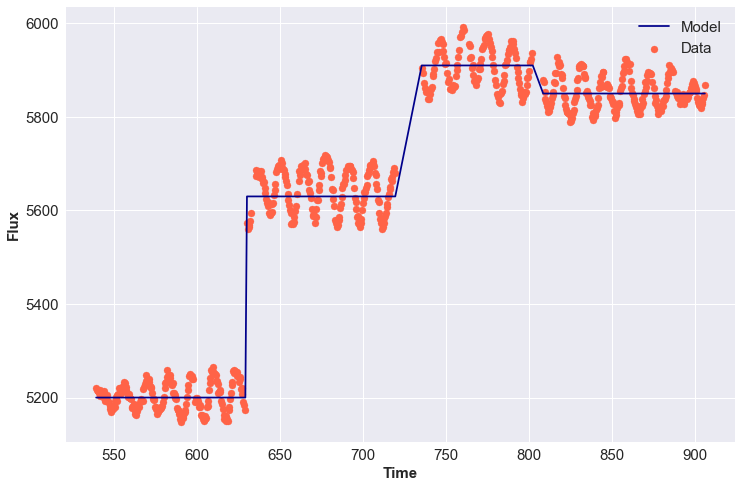

In [94]:
#You need 4 parameters (𝑚,𝑐1,𝑐2,𝑐3) to renormalize the flux to the first cycle
class OffsetModel(Model):
    parameter_names = ("m", "c1", "c2", "c3")

    def get_value(self, t):

        # this gives me the indices of the offsets within the time array
        indices = []
        quarter_vals = sorted(np.unique(tab['quarter']))
        for i in range(len(quarter_vals)):
            quarter_index = tab['quarter'] == quarter_vals[i]
            indices.append((np.abs(t - tab['time'][quarter_index].min())).argmin())

        # this array will output flux values for the model
        flux = np.ones_like(t)
        
        # Indexing the model to specify the location of the offsets
        flux[:indices[1]] = self.m
        flux[indices[1]:indices[2]] = self.m + self.c1
        flux[indices[2]:indices[3]] = self.m + self.c2
        flux[indices[3]:] = self.m + self.c3

        return flux 


# I'm guessing these vals based on the plot
guess_m, guess_c1, guess_c2, guess_c3 = 5200, 430, 710, 650

# plotting to check model so far
plt.figure(figsize = (12,8))
plt.scatter(tab["time"][::20], tab["flux"][::20], color = "tomato", label = "Data")
plt.plot(tab["time"], OffsetModel(guess_m, guess_c1, guess_c2, guess_c3).get_value(tab["time"]), color = "darkblue", label = "Model") 
plt.xlabel('Time', weight = "bold", size = 15)
plt.ylabel('Flux', weight = "bold", size = 15)
plt.legend(loc = "best", prop = {"size":15})
plt.tick_params("both", labelsize = 15)    

### Q3: With your model and likelihood constructured, write down priors on the parameters (you should be able to estimate from the plots)

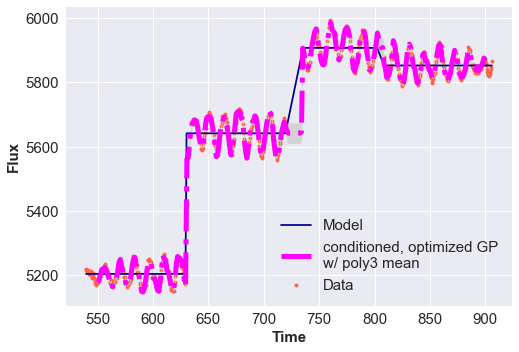

In [188]:
guess_A, guess_gamma, guess_period, guess_lambda = 300, 1, 7, 0.5
k = guess_A * kernels.ExpSine2Kernel(gamma = guess_gamma, log_period = guess_period) * kernels.ExpSquaredKernel(metric = guess_lambda)

def lnprob(p):
    gp.set_parameter_vector(p) 
    
#     intial_guesses = [5.20000000e+03, 4.30000000e+02, 7.10000000e+02, 6.50000000e+02, 5.70378247e+00, 1.00000000e+00, 7.00000000e+00, 1.00000000e-08]
        
#     conditions = np.array([(5000 < p[0] < 5400) and (200  < p[1] < 500) and \
#     (600  < p[2] < 800) and (600  < p[3] < 800) and (0 < p[4] < 10000) and (0 < p[5] < 1000) and \
#                            (0 < p[6] < 20) and (-10 < p[7] < 10)])
    
#     priors_ = 0
#     if np.all(conditions == 1):
#         for i in range(len(conditions)):
#             priors_ += np.log(st.norm.pdf(x = p[i], loc = intial_guesses[i], scale = intial_guesses[i]/5))
#         return  priors_
#     else:
#         return -np.inf

#     # compute the lnlikelihood.
    return gp.lnlikelihood(tab["flux"][::50], quiet=True)# + np.sum(priors_))


def nll(params):
    return -lnprob(params)


gp = GP(kernel = k, mean = OffsetModel(guess_m, guess_c1, guess_c2, guess_c3))
gp.compute(tab["time"][::50])

p0 = gp.get_parameter_vector()
results = minimize(nll, p0, method="L-BFGS-B")
t_new = np.linspace(550,900, len(tab["flux"][::50]))
ypred, cov = gp.predict(tab["flux"][::50], t_new, return_cov = True)
std = np.sqrt(np.diag(cov))

# plot the data
plt.scatter(tab["time"][::20], tab["flux"][::20], color = "tomato", marker = ".", label = "Data")
plt.plot(tab["time"], OffsetModel(results.x[0], results.x[1], results.x[2], results.x[3]).get_value(tab["time"]), color = "darkblue", label = "Model") 
plt.plot(t_new, ypred, ls='-.', label='conditioned, optimized GP\nw/ poly3 mean', color = "magenta",lw=5)
plt.fill_between(t_new, ypred-std, ypred+std, color='lightgrey')
plt.xlabel('Time', weight = "bold", size = 15)
plt.ylabel('Flux', weight = "bold", size = 15)
plt.legend(loc = "best", prop = {"size":15})
plt.tick_params("both", labelsize = 15)  

### Q4: Use `emcee` to optimize the model parameters and hyper-parameters, **using only every 10th sample in time**
### (Don't go overboard with the number of walkers or steps)
https://george.readthedocs.io/en/latest/tutorials/hyper/ may help

In [189]:
initial = gp.get_parameter_vector()
print(initial)
ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

print("Running first burn-in...")
p0 = initial + 1e-4 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 2000)

print("Running second burn-in...")
p0 = p0[np.argmax(lp)] + 1e-4 * np.random.randn(nwalkers, ndim)
sampler.reset()
p0, _, _ = sampler.run_mcmc(p0, 2000)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 2000);

[5.20454104e+03 4.37312110e+02 7.02872509e+02 6.48185778e+02
 6.92124307e+00 9.92281076e-01 6.98848944e+00 5.47736273e-01]
Running first burn-in...
Running second burn-in...
Running production...


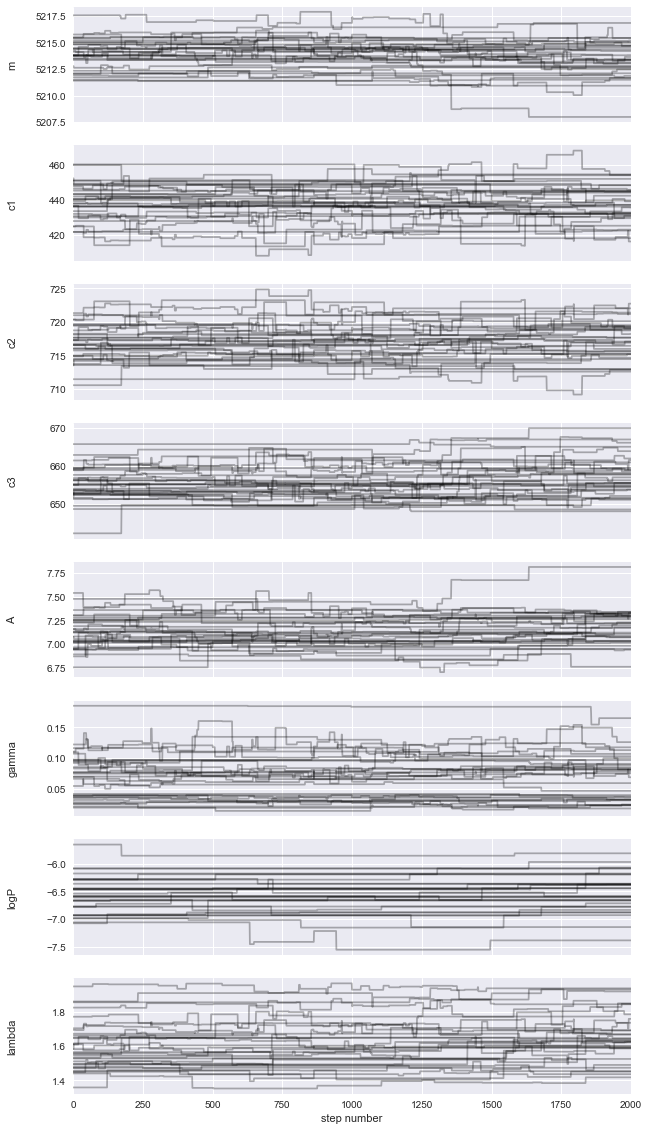

In [190]:
fig, axes = plt.subplots(nrows=8,figsize=(10,20), sharex=True)
samples = sampler.get_chain()
labels = ['m','c1','c2','c3','A','gamma','logP','lambda']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

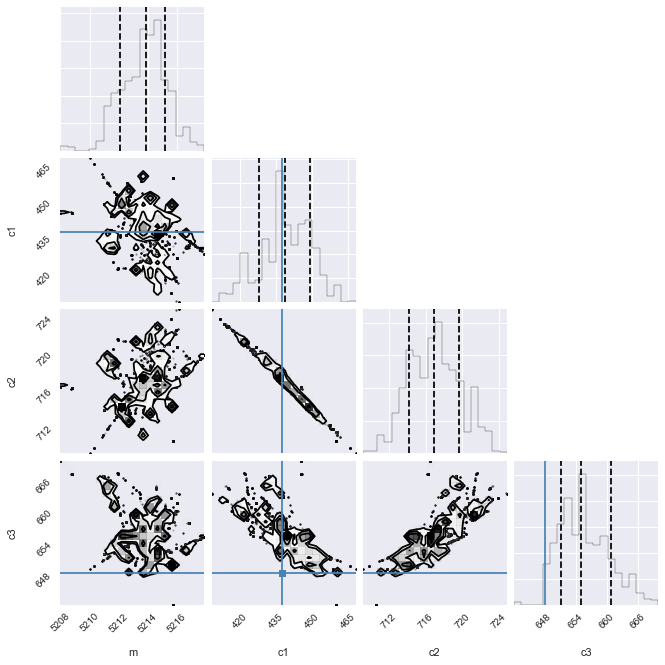

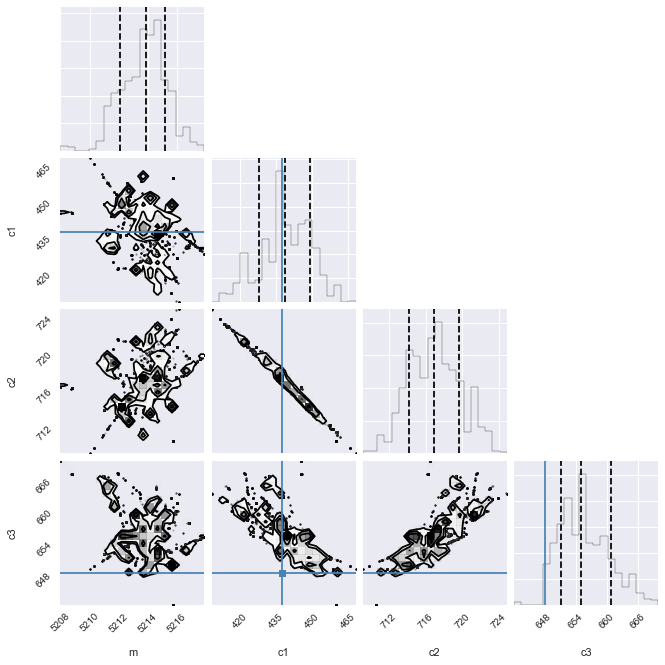

In [191]:
names = gp.get_parameter_names()
indices = np.array([names.index("mean:" + k) for k in ['m','c1','c2','c3']])
corner.corner(sampler.flatchain[:, indices], labels=['m','c1','c2','c3'],truths=results.x,quantiles=[0.16,0.50,0.84])

### Q5: Plot your posterior model over the data after correcting for the offsets, showing the points you used to condition the GP in red, and the remaining data in black. 

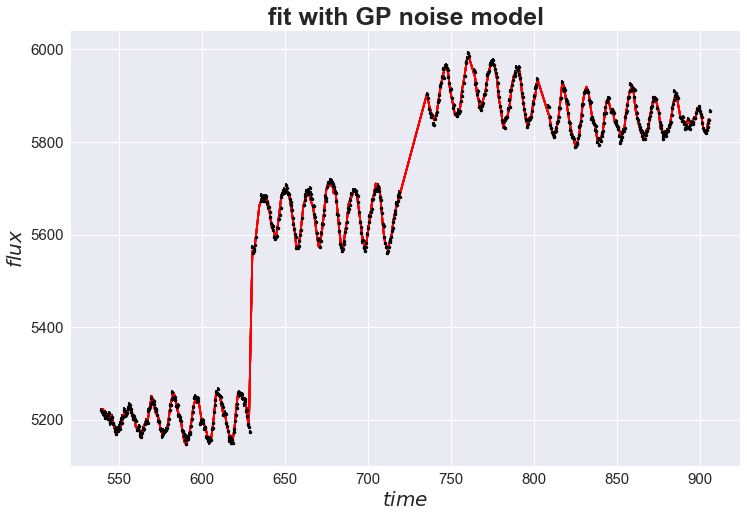

In [193]:
# The positions where the prediction should be computed.
x = np.linspace(np.min(tab["time"]), np.max(tab["time"]), len(tab["flux"][::10]))

plt.figure(figsize = (12,8))

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    gp.set_parameter_vector(s)
    mu = gp.sample_conditional(tab["flux"][::50],tab["time"][::50])
    plt.plot(tab["time"][::50], mu, color="red", alpha=0.3)

plt.errorbar(tab["time"][::20], tab["flux"][::20], yerr = tab["error"][::20], fmt="k.", capsize=0)
plt.ylabel(r"$flux$", weight = "bold", size = 20)
plt.xlabel(r"$time$", weight = "bold", size = 20)
plt.title("fit with GP noise model", weight = "bold", size = 25)
plt.tick_params("both", labelsize = 15)  